In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,BatchNormalization, Flatten, Dense, Dropout

In [ ]:
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MRI BTD Classification dataset','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MRI BTD Classification dataset','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:30<00:00,  2.46it/s]


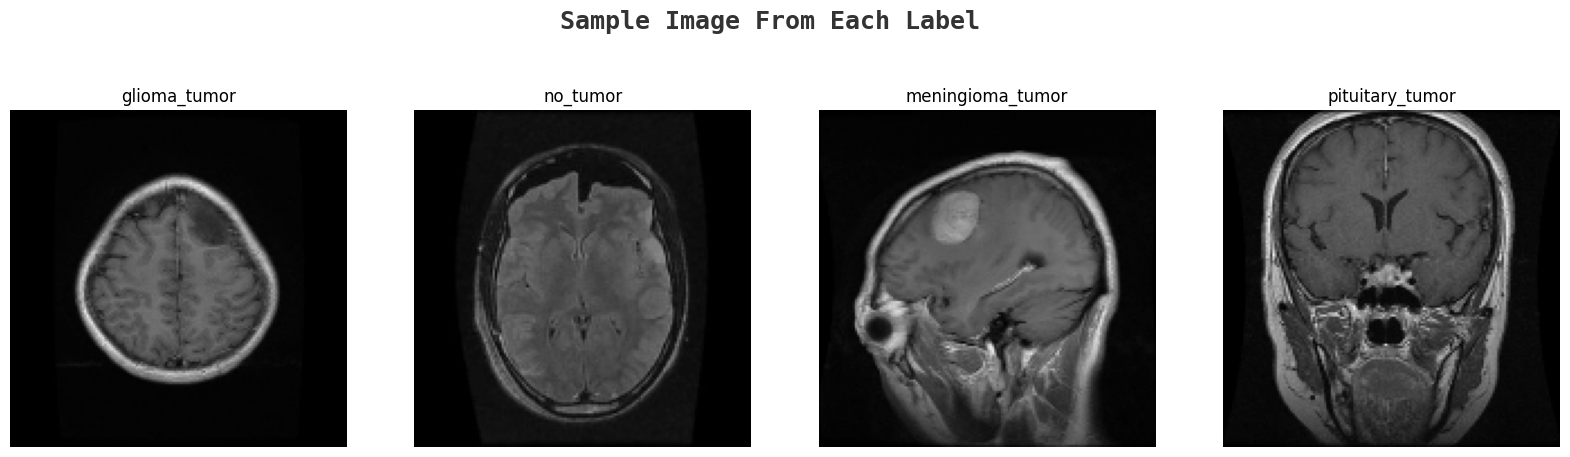

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
X_train.shape

(2946, 150, 150, 3)

In [ ]:
X_test.shape

(328, 150, 150, 3)

In [ ]:
y_train.shape

(2946,)

In [ ]:
y_test.shape

(328,)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)

# Find unique class labels
unique_labels = np.unique(y_test_labels)

print("Unique class labels:", unique_labels)

Unique class labels: [0 1 2 3]


In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.787384 to fit



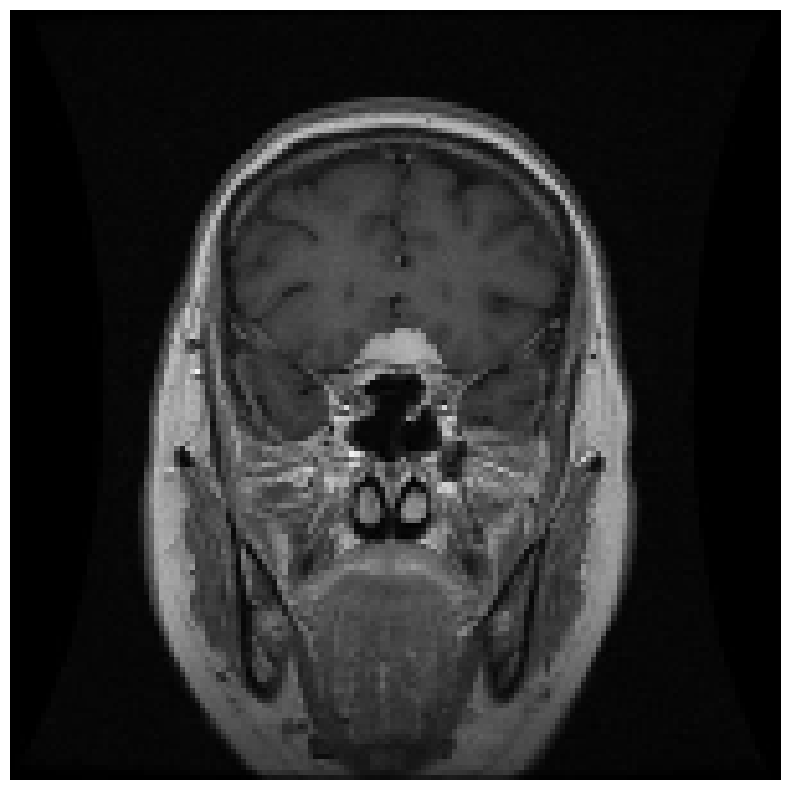

In [ ]:
plot_model(model, show_shapes=True, dpi=150)

# Display the plot
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
83/83 [==============================] - ETA: 0s - loss: 0.4869 - accuracy: 0.8280
Epoch 1: val_accuracy improved from -inf to 0.85763, saving model to effnet.keras
83/83 [==============================] - 511s 6s/step - loss: 0.4869 - accuracy: 0.8280 - val_loss: 0.3860 - val_accuracy: 0.8576 - lr: 0.0010
Epoch 2/5
83/83 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.9412
Epoch 2: val_accuracy improved from 0.85763 to 0.92881, saving model to effnet.keras
83/83 [==============================] - 475s 6s/step - loss: 0.1806 - accuracy: 0.9412 - val_loss: 0.2579 - val_accuracy: 0.9288 - lr: 0.0010
Epoch 3/5
83/83 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9544
Epoch 3: val_accuracy improved from 0.92881 to 0.93220, saving model to effnet.keras
83/83 [==============================] - 465s 6s/step - loss: 0.1302 - accuracy: 0.9544 - val_loss: 0.1636 - val_accuracy: 0.9322 - lr: 0.0010
Epoch 4/5
83/83 [=======================

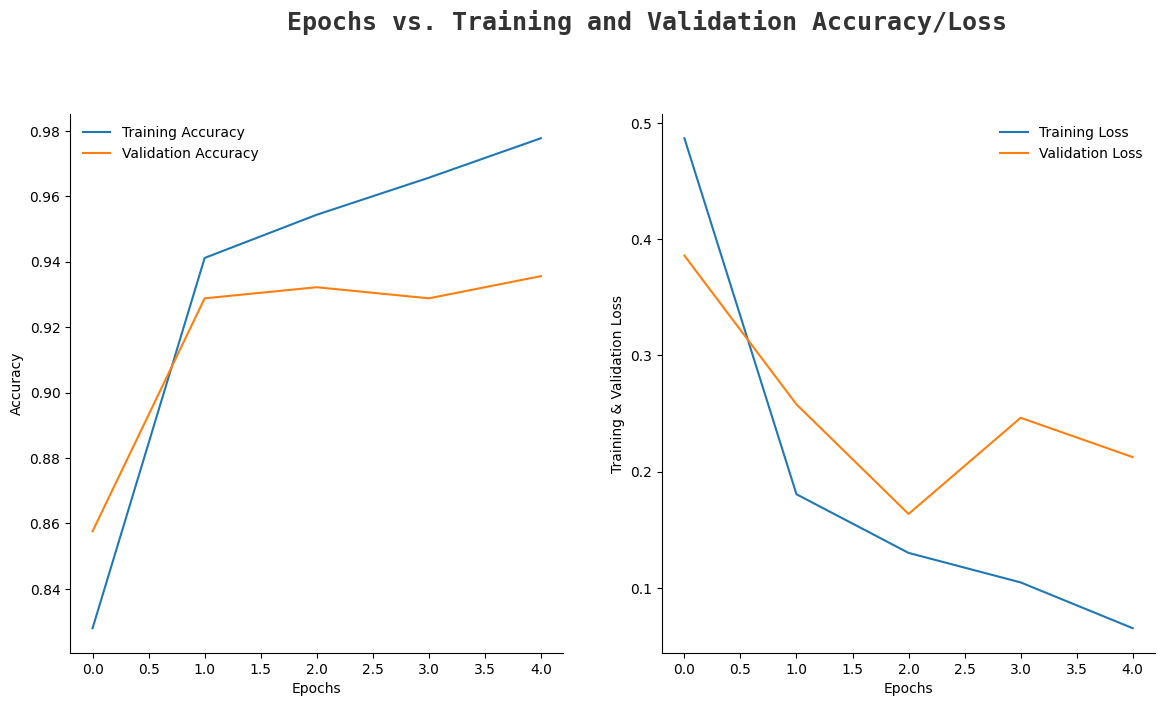

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(5)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss,label ='Training Loss')
ax[1].plot(epochs, val_loss, label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 22s 2s/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        97
           1       0.94      0.98      0.96        51
           2       0.99      0.84      0.91        89
           3       0.92      1.00      0.96        91

    accuracy                           0.95       328
   macro avg       0.95      0.95      0.95       328
weighted avg       0.95      0.95      0.94       328



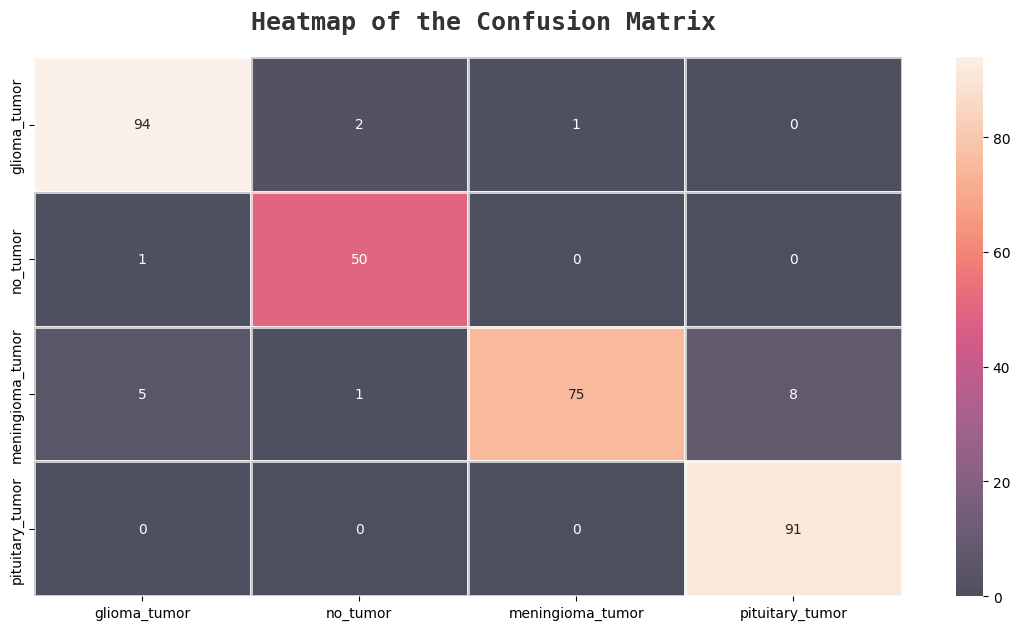

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

**Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Assuming input_dim, hidden_layers, and output_dim are defined according to your specific task
input_dim = 224 * 224 * 3  # Example input dimension (flattened image)
hidden_layers = [256, 128]  # Example hidden layers with 256 and 128 units
output_dim = 4  # Example output dimension (number of classes)

# Define the Deep Belief Network (DBN) model
def build_dbn_model(input_dim, hidden_layers, output_dim):
    model = Sequential()

    # Input layer: Flatten the input images
    model.add(Flatten(input_shape=(224, 224, 3)))

    # Hidden layers
    for units in hidden_layers:
        model.add(Dense(units, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(output_dim, activation='softmax'))

    return model

# Create a DBN model
dbn_model = build_dbn_model(input_dim, hidden_layers, output_dim)

# Compile the model
dbn_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
dbn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 256)               38535424  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 38568836 (147.13 MB)
Trainable params: 385

In [ ]:

# Define callbacks
tensorboard = TensorBoard(log_dir='./logs/dbn')
checkpoint = ModelCheckpoint(filepath='dbn_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001, verbose=1)

In [ ]:
resized_X_train = []
for img in X_train:
    resized_img = cv2.resize(img, (224, 224))
    resized_X_train.append(resized_img)
resized_X_train = np.array(resized_X_train)

In [ ]:
# Train the DBN model
history = dbn_model.fit(resized_X_train, y_train, validation_split=0.1, epochs=20, verbose=1, batch_size=32,
                        callbacks=[tensorboard, checkpoint, reduce_lr])

Epoch 1/20
83/83 [==============================] - 117s 1s/step - loss: 2156.1055 - accuracy: 0.3206 - val_loss: 18.7023 - val_accuracy: 0.2508 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - 123s 1s/step - loss: 18.0172 - accuracy: 0.2663 - val_loss: 17.3221 - val_accuracy: 0.3017 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - 107s 1s/step - loss: 16.9067 - accuracy: 0.2822 - val_loss: 16.4469 - val_accuracy: 0.3017 - lr: 0.0010
Epoch 4/20
83/83 [==============================] - 103s 1s/step - loss: 16.0480 - accuracy: 0.2610 - val_loss: 15.6171 - val_accuracy: 0.2542 - lr: 0.0010
Epoch 5/20
83/83 [==============================] - 107s 1s/step - loss: 15.2624 - accuracy: 0.2739 - val_loss: 14.8316 - val_accuracy: 0.2542 - lr: 0.0010
Epoch 6/20
83/83 [==============================] - 102s 1s/step - loss: 14.6776 - accuracy: 0.2806 - val_loss: 14.3615 - val_accuracy: 0.2542 - lr: 0.0010
Epoch 7/20
83/83 [==============================] - 112s 1s/st

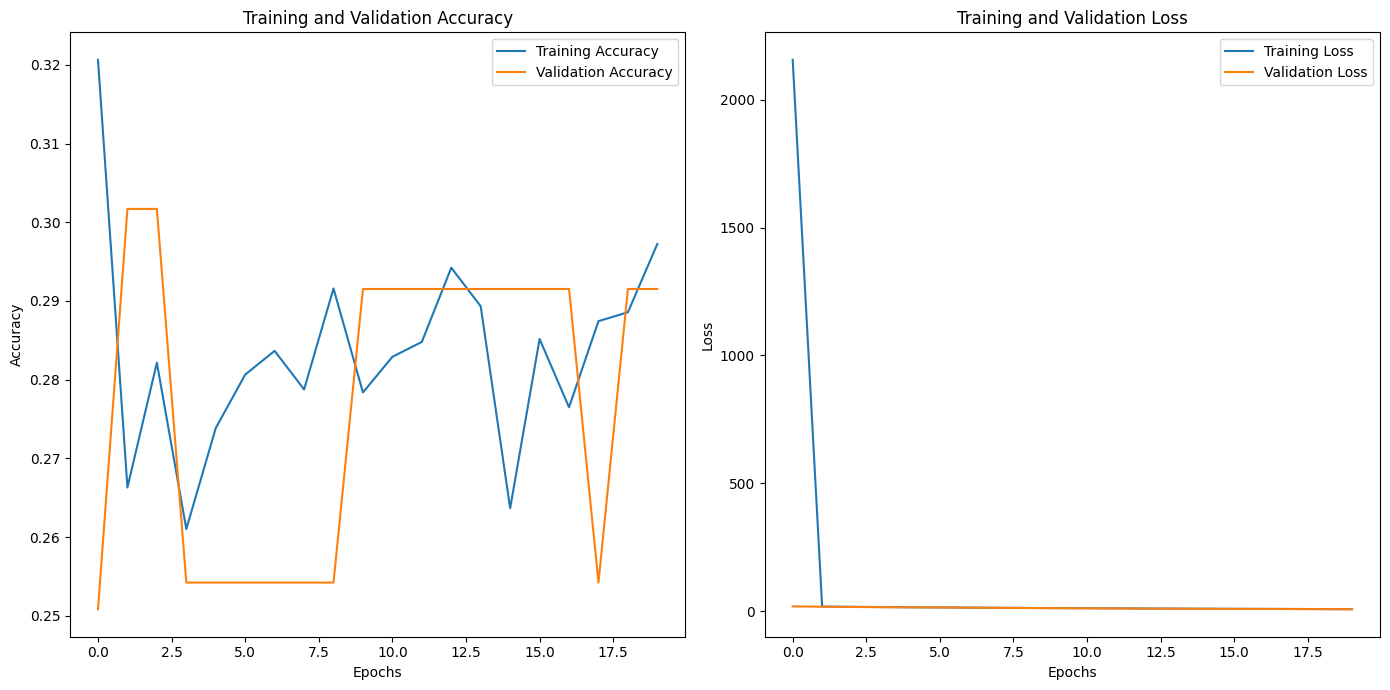

In [ ]:

# Plot training history
plt.figure(figsize=(14, 7))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
resized_X_test = []
for img in X_test:  # Assuming X_test is your original test data
    resized_img = cv2.resize(img, (224, 224))
    resized_X_test.append(resized_img)
resized_X_test = np.array(resized_X_test)

# Evaluate the model on test data
test_loss, test_accuracy = dbn_model.evaluate(resized_X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

11/11 [==============================] - 2s 214ms/step - loss: 7.4603 - accuracy: 0.2713
Test Loss: 7.4603
Test Accuracy: 0.2713


In [ ]:

# Make predictions
predictions = dbn_model.predict(resized_X_test)
y_pred = np.argmax(predictions, axis=1)


11/11 [==============================] - 2s 208ms/step


In [ ]:
# Convert one-hot encoded y_test back to categorical labels
y_test_labels = np.argmax(y_test, axis=1)

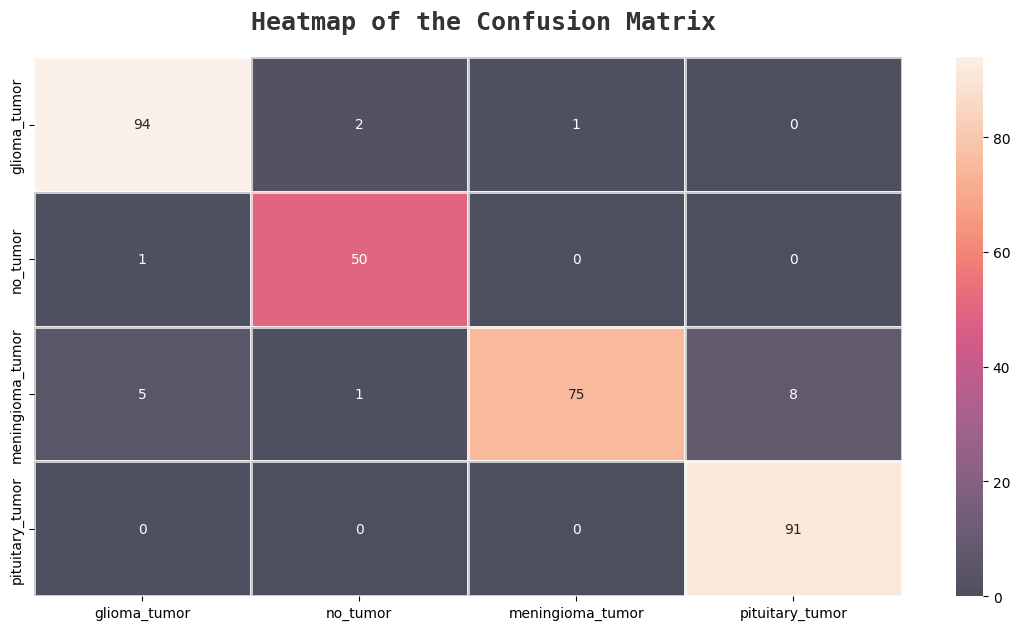

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        97
           1       0.00      0.00      0.00        51
           2       0.27      1.00      0.43        89
           3       0.00      0.00      0.00        91

    accuracy                           0.27       328
   macro avg       0.07      0.25      0.11       328
weighted avg       0.07      0.27      0.12       328



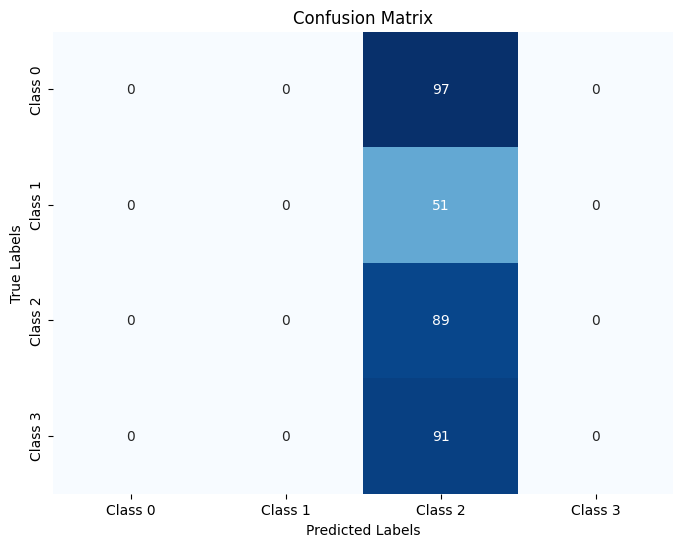

In [ ]:
# Print classification report and confusion matrix
print(classification_report(y_test_labels, y_pred))
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/MRI_Model_Saved/brain_DBN.h5")